In [2]:
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from uncertainties import unumpy as unp
from uncertainties import ufloat, umath

from options import *
from lib import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

## Load

In [3]:
data = load('250321-exp7')

/home/tom/Documents/EPFL/BA5/TPIIIa/05-milieux-granulaires/analyse/lib.py:28: UserWarning: loadtxt: input contained no data: "../data/250321-exp7/250321-exp7_step11.txt"
  freq, psd, chi_abs, chi_im = np.loadtxt(file, skiprows=1, delimiter='\t', unpack=True)


## Noise study and removal

### Noise study

Noise step:  ../data/250321-exp7/250321-exp7_step19.txt


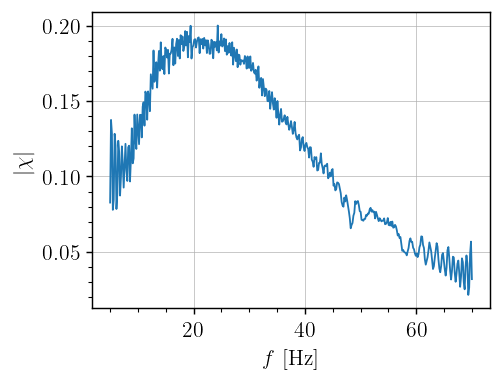

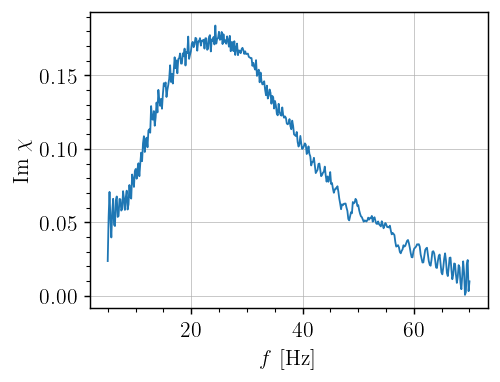

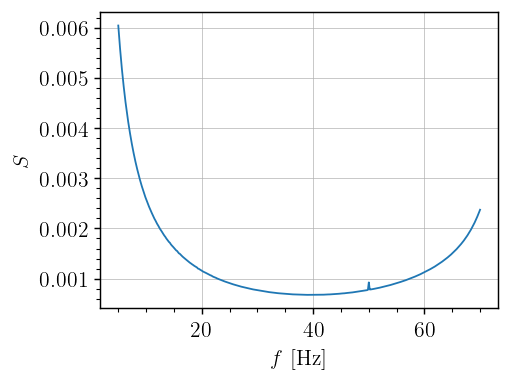

In [4]:
noise = data[-1]
print("Noise step: ", noise.filename)

# === Susceptibility (absolute value)===
plt.plot(noise.freqs, noise.chi_abs)
plt.xlabel("$f$ [Hz]")
plt.ylabel("$| \\chi |$")
plt.show()

# === Susceptibility (imaginary part)===
plt.plot(noise.freqs, noise.chi_im)
plt.xlabel("$f$ [Hz]")
plt.ylabel("{Im} $\\chi $")
plt.show()

# === Power Spectral Density
plt.plot(noise.freqs, noise.psd)
plt.xlabel("$f$ [Hz]")
plt.ylabel("$S$")
plt.show()


### Noise removal

In [5]:
data.pop(-1) # remove noise from interesting data
for i, step in enumerate(data):
    step.psd /= noise.psd
    step.chi_im /= noise.chi_im
    step.chi_abs /= noise.chi_abs

## Do fits

[I, omega, alpha] =  [1.10263796e-05 4.84186684e+01 1.83082390e-04]


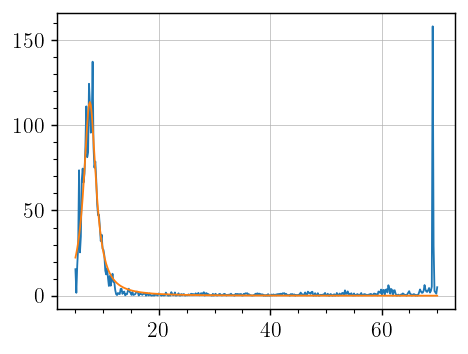

[I, omega, alpha] =  [1.09140968e-05 4.92970951e+01 1.82001640e-04]


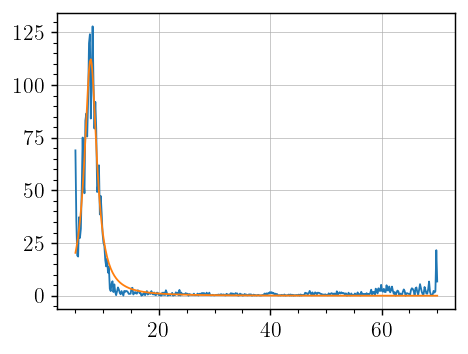

[I, omega, alpha] =  [1.16007409e-05 4.85640148e+01 2.09464865e-04]


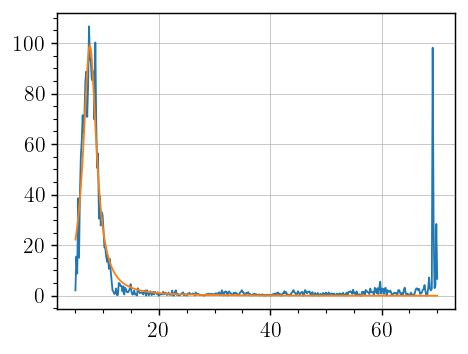

[I, omega, alpha] =  [1.19091107e-05 4.90894449e+01 1.87816237e-04]


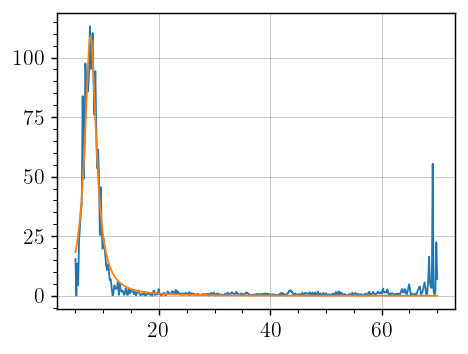

[I, omega, alpha] =  [1.05085773e-05 4.91091942e+01 2.25398993e-04]


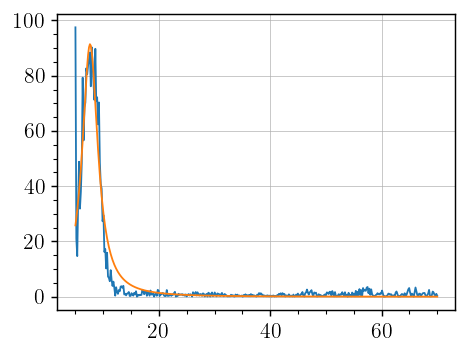

[I, omega, alpha] =  [9.73678441e-06 4.87378748e+01 2.05667702e-04]


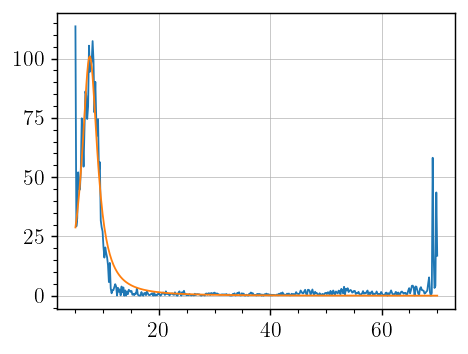

[I, omega, alpha] =  [1.05221404e-05 4.80839307e+01 2.34496650e-04]


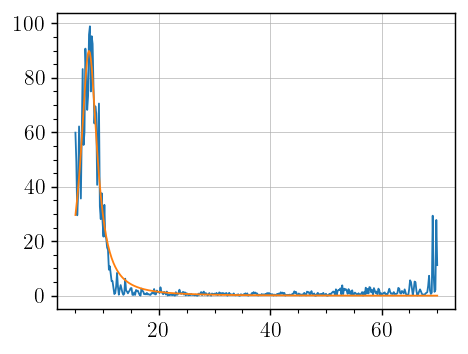

[I, omega, alpha] =  [5.43434178e-06 3.11740731e+01 4.05150320e-04]


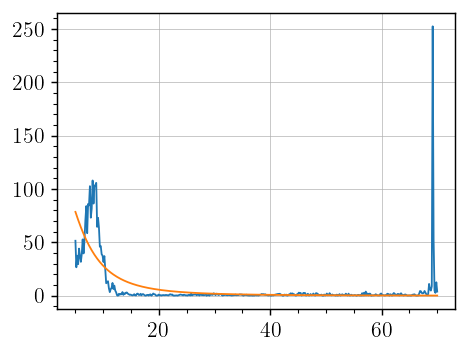

[I, omega, alpha] =  [1.35361396e-05 4.93553213e+01 3.11571504e-04]


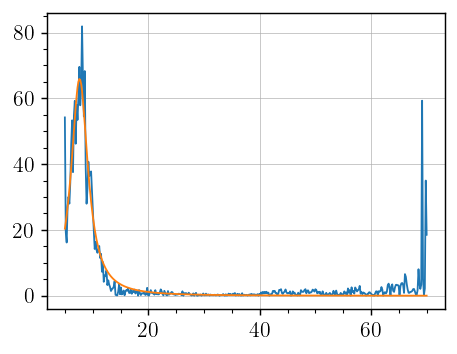

[I, omega, alpha] =  [1.07992015e-05 5.05614733e+01 2.39121779e-04]


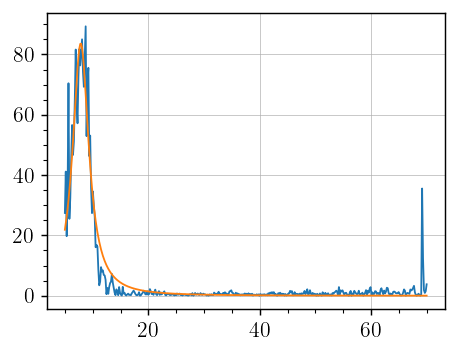

[I, omega, alpha] =  [1.12151651e-05 5.19110169e+01 2.30795516e-04]


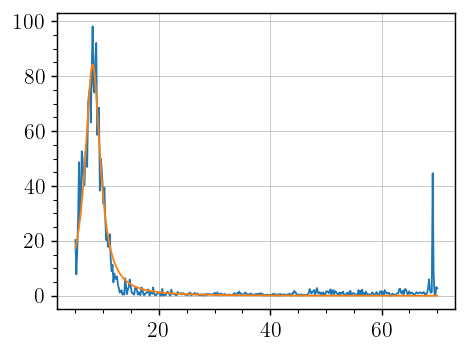

[I, omega, alpha] =  [1.13007207e-05 5.31095476e+01 2.50337222e-04]


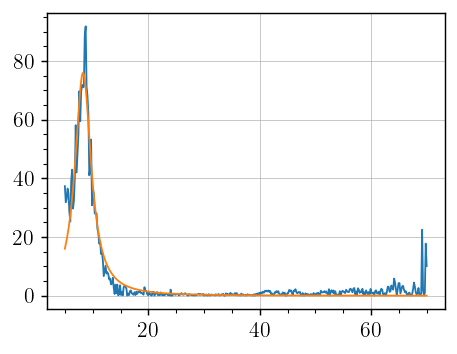

[I, omega, alpha] =  [1.01076681e-05 5.29534985e+01 2.62482927e-04]


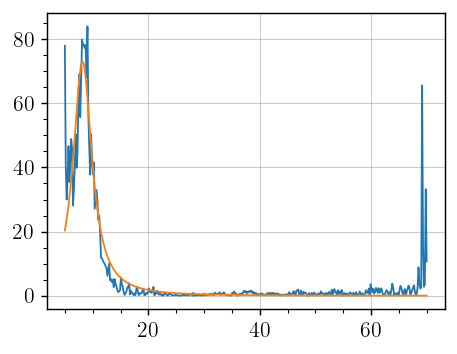

[I, omega, alpha] =  [1.12814211e-05 5.63671331e+01 3.84083328e-04]


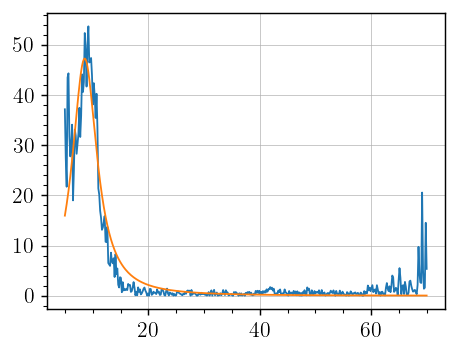

[I, omega, alpha] =  [1.36091790e-05 6.05919606e+01 4.06685739e-04]


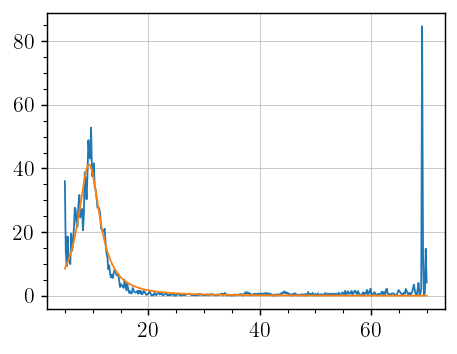

[I, omega, alpha] =  [1.36261422e-05 6.14636639e+01 3.99972880e-04]


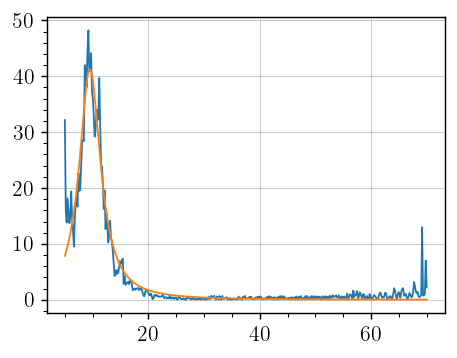

[I, omega, alpha] =  [1.56628601e-05 6.63588425e+01 8.94618319e-04]


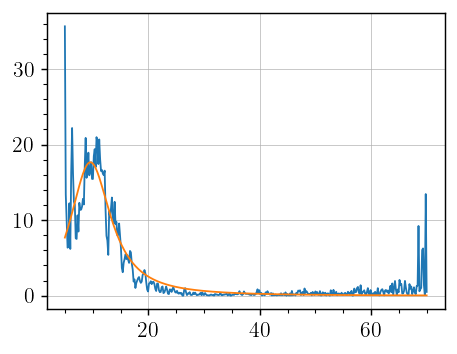

[I, omega, alpha] =  [1.84726266e-05 7.11691537e+01 2.09275069e-03]


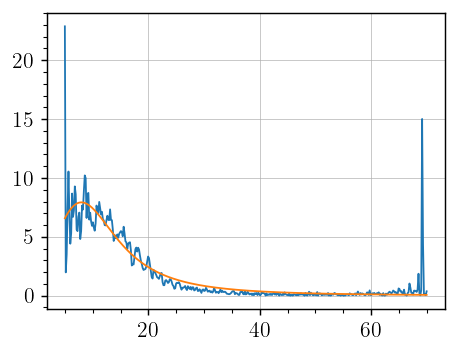

In [6]:
show_plots = True

all_popt_err_pass1 = unp.uarray(np.zeros((len(data), 3)), 0)
for i, step in enumerate(data):
    popt, pcov = sc.optimize.curve_fit(
        imag_chi, step.freqs, step.chi_im,
        bounds=(0, np.inf)
    )
    all_popt_err_pass1[i] = unp.uarray(popt, np.sqrt(np.diag(pcov)))

    if show_plots:
        if step.imposed_vibration < 1e-4:
            print("WARNING: THIS IS NOISE")
        print("[I, omega, alpha] = ", popt)
        plt.plot(step.freqs, step.chi_im)
        plt.plot(step.freqs, imag_chi(step.freqs, *popt))
        plt.show()

I, w0, _ = np.mean(all_popt_err_pass1, axis=0)
dI, dw0, _ = std_devs(np.mean(all_popt_err_pass1, axis=0))
all_popt_err_pass2 = np.zeros_like(all_popt_err_pass1)

for i, step in enumerate(data):
    popt, pcov = sc.optimize.curve_fit(
        imag_chi, step.freqs, step.chi_im,
        bounds=(
            (I.n - dI, w0.n - dw0, 0),
            (I.n + dI, w0.n + dw0, np.inf)
        )
    )
    all_popt_err_pass2[i] = unp.uarray(popt, np.sqrt(np.diag(pcov)))

    # if show_plots:
    #     if step.imposed_vibration < 1e-4:
    #         print("WARNING: THIS IS NOISE")
    #     print("[I, omega, alpha] = ", popt)
    #     plt.plot(step.freqs, step.chi_im)
    #     plt.plot(step.freqs, modulus_chi(step.freqs, *popt))
    #     plt.show()

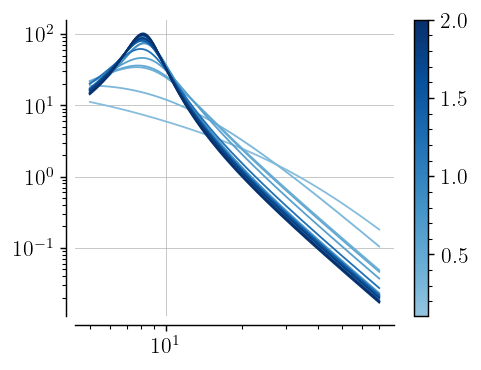

In [7]:
max_amplitude = max(step.imposed_vibration for step in data)
min_amplitude = min(step.imposed_vibration for step in data)

cmap = truncate_colormap(plt.cm.Blues, 0.4, 1.0)
norm = mpl.colors.Normalize(vmin=min_amplitude, vmax=max_amplitude)

fig, ax = plt.subplots()

for i, (popt, step) in enumerate(zip(reversed(nom_vals(all_popt_err_pass2)), reversed(data))):
    color = cmap(step.imposed_vibration / max_amplitude)
    fitted = imag_chi(step.freqs, *popt)
    # ax.loglog(step.freqs, step.chi_abs, c=color)
    ax.loglog(step.freqs, fitted, c=color)

# plt.colorbar()
fig.colorbar(plt.cm.ScalarMappable(norm, cmap), ax=ax)

ax.spines[['top', 'right']].set_visible(False)
ax.spines[['bottom', 'left']].set_position(('outward', 5))
ax.grid(True, axis='y')
# ax.set_xlim(1e1, 4e1)
# ax.set_ylim(5e-2, 1e1)

## Average $I$, $\omega_0$ and $\alpha$

In [8]:
I, omega0, alpha = np.mean(all_popt_err_pass1, axis=0)
print(f"{I = :.5f} g m²")
print(f"{omega0 = :.5f} Hz")
print(f"{alpha = :.5f} g m² s⁻¹")
I, omega0, alpha = np.mean(all_popt_err_pass2, axis=0)
print(f"{I = :.5f} g m²")
print(f"{omega0 = :.5f} Hz")
print(f"{alpha = :.5f} g m² s⁻¹")

I = 0.00001+/-0.00000 g m²
omega0 = 52.57311+/-0.93023 Hz
alpha = 0.00041+/-0.00001 g m² s⁻¹
I = 0.00001+/-0.00000 g m²
omega0 = 52.30752+/-0.46773 Hz
alpha = 0.00047+/-0.00001 g m² s⁻¹


[-0.82241873 -8.17605146]


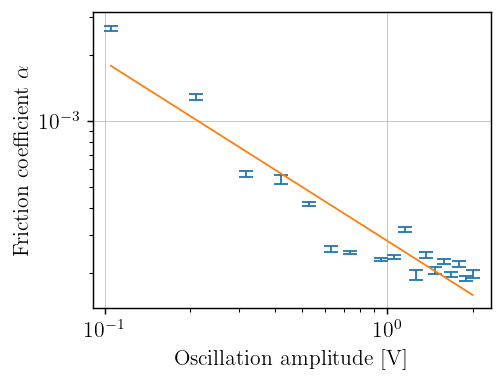

In [10]:
amplitude = np.array([step.imposed_vibration for step in data])
alpha = nom_vals(all_popt_err_pass2)[:, 2]
alpha_err = std_devs(all_popt_err_pass2)[:, 2]

plt.errorbar(amplitude, alpha, yerr=alpha_err, ls='none')

# Weighted fit
coefs, cov = np.polyfit(np.log(amplitude), np.log(alpha), 1, cov=True)  # , w=1/alpha_err)
xx = np.linspace(np.min(amplitude), np.max(amplitude), 50)
yy = np.exp(np.polyval(coefs, np.log(xx)))
plt.plot(xx, yy)
print(coefs)


plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'Oscillation amplitude [V]')
plt.ylabel(r'Friction coefficient $\alpha$')

plt.show()